In [1]:
import random

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.autograd as autograd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Seed:", manualSeed)

Seed: 5212


In [2]:
# Edit to View and Create More Images

batch_size = 128
img_shape = (1, 64, 64)

# Create the Datasets

transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset_mountains = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_two = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_three = dset.ImageFolder(root="../data/mountains", transform=transform)

dataloader_mountains = torch.utils.data.DataLoader(dataset_mountains, batch_size=batch_size, shuffle=True, num_workers=8)
dataloader_two = torch.utils.data.DataLoader(dataset_two, batch_size=batch_size, shuffle=True, num_workers=8)
dataloader_three = torch.utils.data.DataLoader(dataset_three, batch_size=batch_size, shuffle=True, num_workers=8)

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print("Running On Cuda:", cuda)

Running On Cuda: True


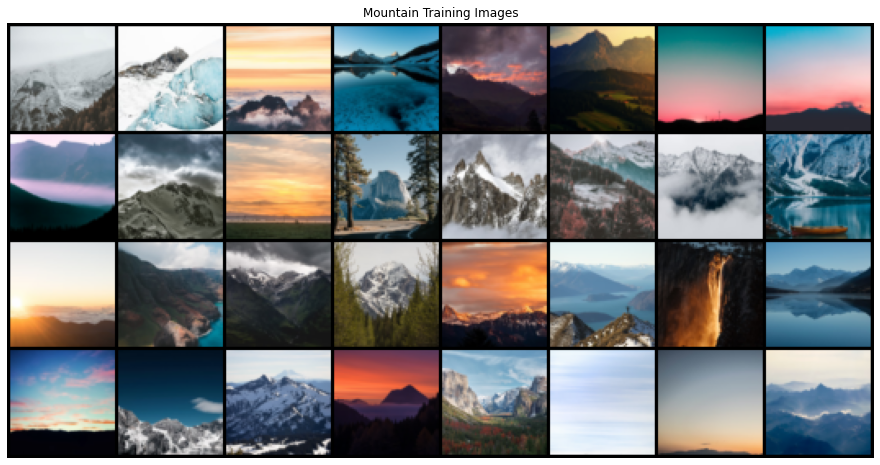

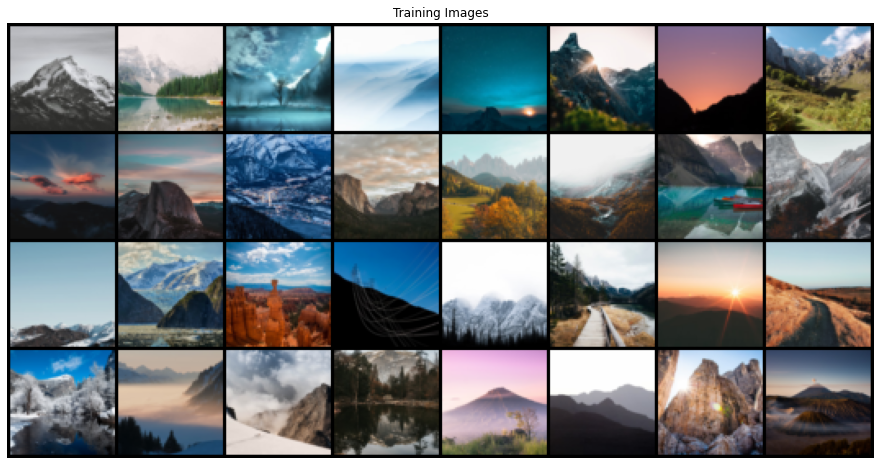

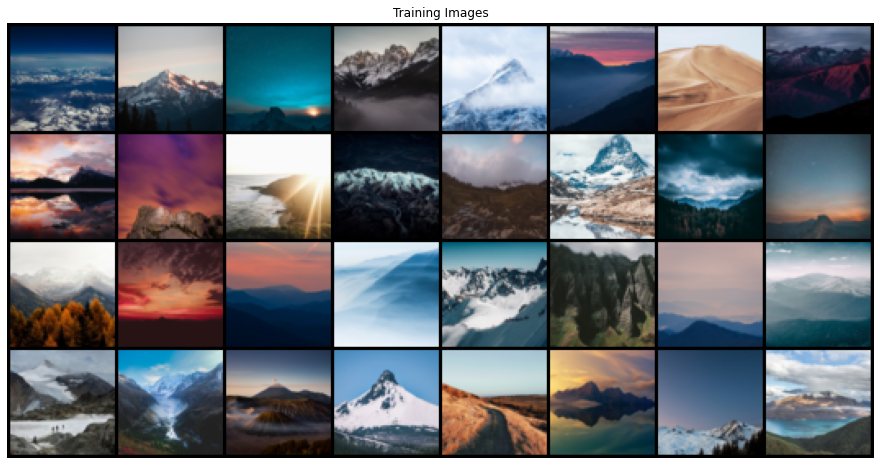

In [3]:
# Show Some Training Images

real_batch = next(iter(dataloader_mountains))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Mountain Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)));

real_batch = next(iter(dataloader_two))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)));

real_batch = next(iter(dataloader_three))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)));

In [4]:
def show_results(dataloader, img_list):
    
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

In [5]:
def do_run(dataloader, epochs):

    netG = Generator()
    netD = Discriminator()

    if cuda:
        
        netG.cuda()
        netD.cuda()
        
    img_list = main_loop(dataloader, netG, netD, epochs)
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    show_results(dataloader, img_list)

## Traditional GAN

To begin with, we attempt to run a traditional GAN on the three datasets.

In [6]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        def block(in_feat, out_feat, normalize=True):
            
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
                
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        
        return img


In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [8]:
def main_loop(dataloader, netD, netG, epochs):
    
    adversarial_loss = torch.nn.BCELoss()

    if cuda:
        
        adversarial_loss.cuda()

    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        
        for i, (imgs, _) in enumerate(dataloader):

            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            # Generate a batch of images
            gen_imgs = netG(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(netD(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(netD(real_imgs), valid)
            fake_loss = adversarial_loss(netD(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch, epochs, d_loss.item(), g_loss.item()))
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
                    
                with torch.no_grad():

                    fake = netG(z).detach().cpu()
                
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
            iters += 1

In [9]:
do_run(dataloader_mountains, 50)

RuntimeError: size mismatch, m1: [128 x 100], m2: [4096 x 512] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [ ]:
do_run(dataloader_two, 50)

In [ ]:
do_run(dataloader_three, 50)

## Wasserstein GAN

The Wasserstein GAN [(paper here)](https://arxiv.org/abs/1701.07875) is a improve GAN model that improves learning 
stability and helps get rid of problems like mode collapse, which we experienced with our first GAN model.

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        def block(in_feat, out_feat, normalize=True):
            
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):

    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [ ]:
def main_loop(dataloader, netD, netG, epochs):
    
    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training Loop

    img_list = []
    iters = 0
    
    for epoch in range(epochs):
    
        for i, (imgs, _) in enumerate(dataloader):

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            # Generate a batch of images
            fake_imgs = netG(z)

            # Real images
            real_validity = netD(real_imgs)
            # Fake images
            fake_validity = netD(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(netD, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % 5 == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_imgs = netG(z)
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = netD(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

                print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch, epochs, d_loss.item(), g_loss.item()))
            
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
                    
                    with torch.no_grad():

                        fake = netG(z).detach().cpu()
                
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
                iters += 1

In [ ]:
do_run(dataloader, 50)

In [ ]:
do_run(dataloader_two, 50)

In [ ]:
do_run(dataloader_three, 50)

## Relativistic Average GAN

In [ ]:
class Generator(nn.Module, ngpu):
    
    def __init__(self):
        
        super(Generator, self).__init__()

        self.init_size = 64 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        
        return img

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            
            if bn:
                
                block.append(nn.BatchNorm2d(out_filters, 0.8))
           
            return block

        self.ngpu = ngpu
        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = 64 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
def main_loop(dataloader, netD, netG, epochs):

    adversarial_loss = torch.nn.BCEWithLogitsLoss().to(device)

    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training Loop

    img_list = []
    iters = 0
    
    for epoch in range(epochs):
        
        for i, (imgs, _) in enumerate(dataloader):

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            # Generate a batch of images
            gen_imgs = netG(z)

            real_pred = netD(real_imgs).detach()
            fake_pred = netD(gen_imgs)

            g_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), valid)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(netD(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Predict validity
            real_pred = netD(real_imgs)
            fake_pred = netD(gen_imgs.detach())

            real_loss = adversarial_loss(real_pred - fake_pred.mean(0, keepdim=True), valid)
            fake_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), fake)

            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch, epochs, d_loss.item(), g_loss.item()))

            if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
                    
                with torch.no_grad():

                    fake = netG(z).detach().cpu()
                
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1

In [ ]:
do_run(dataloader_mountains, 50)

In [ ]:
do_run(dataloader_two, 50)

In [ ]:
do_run(dataloader_three, 50)